## Config include
- yolact_edge_resnet50_config
- yolact_edge_vid_resnet50_config
- yolact_edge_vid_trainflow_resnet50_config
- yolact_edge_youtubevis_resnet50_config
- yolact_edge_youtubevis_config
- yolact_resnet50_config
- yolact_resnet152_config

## 读入实例分割网络模型

In [1]:
from eval import *
from yolact_edge.utils.logging_helper import setup_logger

parse_args([])
# parse_args(["--config=yolact_edge_mobilenetv2_config"])
# parse_args(["--config=yolact_edge_54_config", "--calib_images=../calib_images"])

from eval import args

# yolact_edge_mobilenetv2_54_800000.pth   yolact_edge_54_800000.pth yolact_edge_resnet50_54_800000.pth
args.trained_model = "./weights/yolact_edge_mobilenetv2_54_800000.pth"

if args.config is not None:
    set_cfg(args.config)

if args.config is None:
    model_path = SavePath.from_str(args.trained_model)
    # TODO: Bad practice? Probably want to do a name lookup instead.
    args.config = model_path.model_name + '_config'
    print('Config not specified. Parsed %s from the file name.\n' % args.config)
    set_cfg(args.config)

setup_logger(logging_level=logging.INFO)
logger = logging.getLogger("yolact.eval")

Config not specified. Parsed yolact_edge_mobilenetv2_config from the file name.



In [2]:
# args.yolact_transfer = True

torch.set_default_tensor_type('torch.cuda.FloatTensor')
with torch.no_grad():
    logger.info('Loading model...')
    net = Yolact(training=False)
    net.load_weights(args.trained_model, args=args)
    net.eval()
    logger.info('Model loaded.')

    net.detect.use_fast_nms = args.fast_nms
    cfg.mask_proto_debug = args.mask_proto_debug

    args.score_threshold = 0.08
    args.top_k = 15

[05/04 17:41:13 yolact.eval]: Loading model...
[05/04 17:41:34 yolact.eval]: Model loaded.


In [3]:
with torch.no_grad():
    convert_to_tensorrt(net, cfg, args, transform=BaseTransform())

torch2trt_backbone_int8
torch2trt_protonet_int8
torch2trt_fpn
torch2trt_prediction_module
[05/04 17:41:38 yolact.eval]: Converting to TensorRT...
[05/04 17:41:38 yolact.eval]: Converting backbone to TensorRT...
[05/04 17:42:19 yolact.eval]: Converting protonet to TensorRT...


[TensorRT] WARNING: TensorRT was linked against cuBLAS/cuBLAS LT 11.3.0 but loaded cuBLAS/cuBLAS LT 11.2.0
[TensorRT] WARNING: TensorRT was linked against cuBLAS/cuBLAS LT 11.3.0 but loaded cuBLAS/cuBLAS LT 11.2.0


[05/04 17:42:24 yolact.eval]: Converting FPN to TensorRT...


[TensorRT] WARNING: TensorRT was linked against cuBLAS/cuBLAS LT 11.3.0 but loaded cuBLAS/cuBLAS LT 11.2.0
[TensorRT] WARNING: TensorRT was linked against cuBLAS/cuBLAS LT 11.3.0 but loaded cuBLAS/cuBLAS LT 11.2.0
[TensorRT] WARNING: TensorRT was linked against cuBLAS/cuBLAS LT 11.3.0 but loaded cuBLAS/cuBLAS LT 11.2.0


[05/04 17:42:34 yolact.eval]: Converting PredictionModule to TensorRT...


[TensorRT] WARNING: TensorRT was linked against cuBLAS/cuBLAS LT 11.3.0 but loaded cuBLAS/cuBLAS LT 11.2.0
[TensorRT] WARNING: TensorRT was linked against cuBLAS/cuBLAS LT 11.3.0 but loaded cuBLAS/cuBLAS LT 11.2.0
[TensorRT] WARNING: TensorRT was linked against cuBLAS/cuBLAS LT 11.3.0 but loaded cuBLAS/cuBLAS LT 11.2.0
[TensorRT] WARNING: TensorRT was linked against cuBLAS/cuBLAS LT 11.3.0 but loaded cuBLAS/cuBLAS LT 11.2.0
[TensorRT] WARNING: TensorRT was linked against cuBLAS/cuBLAS LT 11.3.0 but loaded cuBLAS/cuBLAS LT 11.2.0


[05/04 17:42:51 yolact.eval]: Converted to TensorRT.


## 确定实例分割问题图像

In [4]:
import glob
images_path = "/home/wxl/Data/TUM/rgbd_dataset_freiburg3_walking_xyz/rgb/"
images = sorted(glob.glob(images_path + "*.png"))   # i = 137

In [7]:
im = cv2.imread('/home/wxl/graduate/graduate_design/yolact_edge/tim.jpg')
frame = torch.from_numpy(im).cuda().float()
batch = FastBaseTransform()(frame.unsqueeze(0))

extras = {"backbone": "full", "interrupt": False, "keep_statistics": False,
          "moving_statistics": None}
preds = ''
with torch.no_grad():
    preds = net(batch, extras=extras)["pred_outs"]

# Visualize the predictions
img_numpy = prep_display(preds, frame, None, None, undo_transform=False)

# plt.figure(figsize=(10,10))
# plt.imshow(img_numpy[:,:,::-1])
cv2.imwrite('picture3_6.png',img_numpy)

True

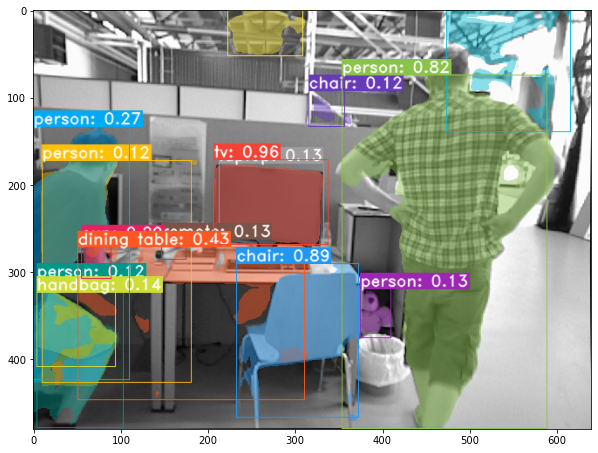

In [6]:
i =47
im = cv2.imread(images[i])
gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
size = gray.shape
im = gray.reshape((size[0],size[1], -1))
frame = torch.from_numpy(im).cuda().float()
batch = FastBaseTransform()(frame.unsqueeze(0))

extras = {"backbone": "full", "interrupt": False, "keep_statistics": False,
          "moving_statistics": None}
preds = ''
with torch.no_grad():
    preds = net(batch, extras=extras)["pred_outs"]

# Visualize the predictions
img_numpy = prep_display(preds, frame, None, None, undo_transform=False)

plt.figure(figsize=(10,10))
plt.imshow(img_numpy[:,:,::-1])

## 测试网络速度

Predict image use 1320.000 ms
Predict image use 678.000 ms
Predict image use 464.333 ms
Predict image use 357.250 ms
Predict image use 292.800 ms
Predict image use 249.833 ms
Predict image use 219.000 ms
Predict image use 196.000 ms
Predict image use 178.444 ms
Predict image use 164.000 ms
FPS: 6.096


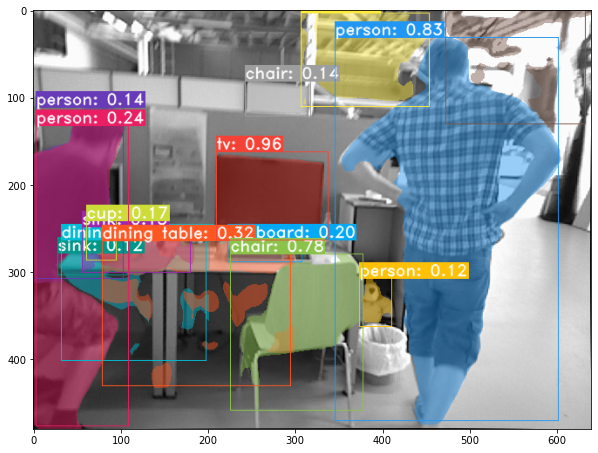

In [39]:
# !wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
# im = cv2.imread("./data/rgb.png")
import matplotlib.pyplot as plt
# im = cv2.imread(r"/home/wxl/graduate/graduate_design/myKmeans/python/images/hope_rgb.png")
im = cv2.imread(images[49])

gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

size = gray.shape
im = gray.reshape((size[0],size[1], -1))
import time
frame = torch.from_numpy(im).cuda().float()
batch = FastBaseTransform()(frame.unsqueeze(0))

extras = {"backbone": "full", "interrupt": False, "keep_statistics": False,
          "moving_statistics": None}
preds = ''
with torch.no_grad():
    t3 = time.time() # wxl
    for i in range(10):
        preds = net(batch, extras=extras)["pred_outs"]
        t4 = time.time() # wxl
        print('Predict image use {:.3f} ms'.format( round( (t4 - t3)*1000 )/(i+1) ))
    print('FPS: {:.3f}'.format((i+1)/(t4 - t3)) ) 
    preds_temp = net(batch, extras=extras)["pred_outs"]

# Visualize the predictions
img_numpy = prep_display(preds_temp, frame, None, None, undo_transform=False)
plt.figure(figsize=(10,10))
plt.imshow(img_numpy[:,:,::-1])

## 处理网络结果

In [40]:
h, w = 480, 640
t = postprocess(preds, w, h, visualize_lincomb = args.display_lincomb,
                                        crop_masks        = args.crop,
                                        score_threshold   = args.score_threshold)

## 生成动态物体掩码

In [125]:
images[i]

'/home/wxl/Data/TUM/rgbd_dataset_freiburg3_walking_xyz/rgb/1341846315.397962.png'

True

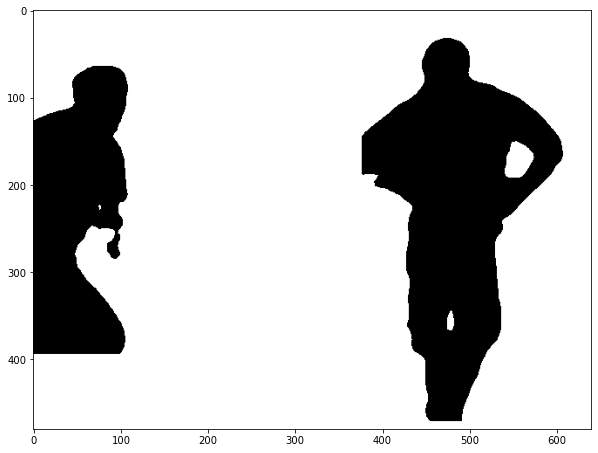

In [124]:
i=55
im = cv2.imread(images[i])
gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
size = gray.shape
im = gray.reshape((size[0],size[1], -1))
frame = torch.from_numpy(im).cuda().float()
batch = FastBaseTransform()(frame.unsqueeze(0))

extras = {"backbone": "full", "interrupt": False, "keep_statistics": False,
          "moving_statistics": None}
preds = ''
with torch.no_grad():
    preds = net(batch, extras=extras)["pred_outs"]

h, w = 480, 640
t = postprocess(preds, w, h, visualize_lincomb = args.display_lincomb,
                                        crop_masks        = args.crop,
                                        score_threshold   = args.score_threshold)

idx = torch.nonzero(t[0]==0).squeeze()  # 筛选所有是人的 index
masks = torch.index_select(t[3], 0, idx)
classes, scores, boxes = [torch.index_select(x, 0, idx).cpu().numpy() for x in t[:3]]

temp = np.ones((frame.shape[0],frame.shape[1]))*255
mat_zeros = np.zeros((frame.shape[0],frame.shape[1]))

frame = temp.astype(np.uint8)
for select in range(len(classes)):  # for select in range(len(classes)):
    if scores[select] < 0.1:
        continue
    x1, y1, x2, y2 = boxes[select].astype(np.int16)
    mask = masks[select][y1:y2, x1:x2].cpu().numpy() > 0.3
    temp[y1:y2, x1:x2][mask] = mat_zeros[y1:y2, x1:x2][mask]
temp.astype(np.uint8)
plt.figure(figsize=(10,10))
plt.imshow(temp,'gray')
cv2.imwrite('./results/hope_mask.png',temp)

## 读入并分析处理区域生长分割图像

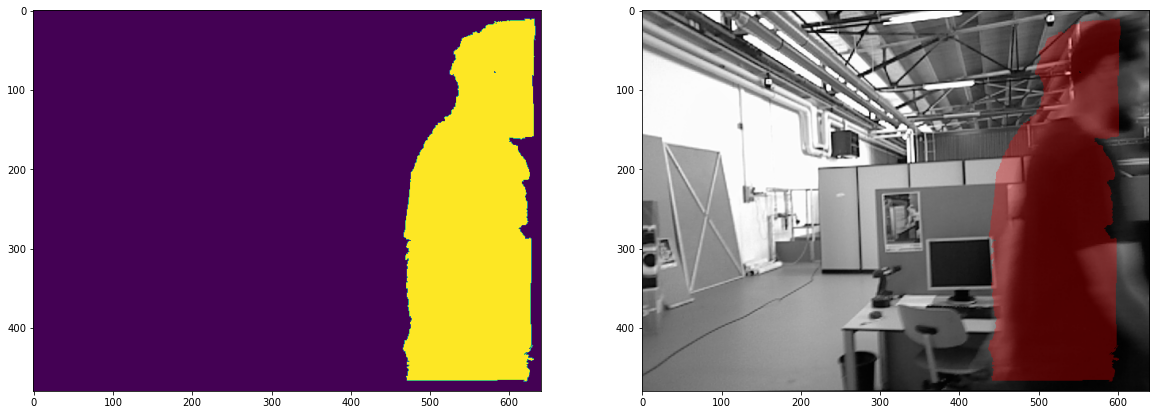

In [42]:
mask_grow = cv2.imread("./data/result2.png",-1)

mask_temp = mask_grow == 1
mask_new = np.zeros(mask_grow.shape)
mask_new[mask_temp] = mask_grow[mask_temp]
mask_new2 = np.zeros(mask_grow.shape)
mask_new2[:,30:] = mask_new[:,:-30]
mask_temp = mask_new > 0

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(mask_new2)

temp = np.zeros((frame.shape[0],frame.shape[1],3))
for i in range(3):
    temp[:,:,i] = gray[:,:]
frame = temp.astype(np.uint8)
roi = frame[mask_temp]
frame[mask_temp] = ([0.3*255, 0.3*0, 0.3*0] + 0.7 * roi).astype(np.uint8)
plt.subplot(1,2,2)
plt.imshow(frame)

## 绘制网络结果蒙版

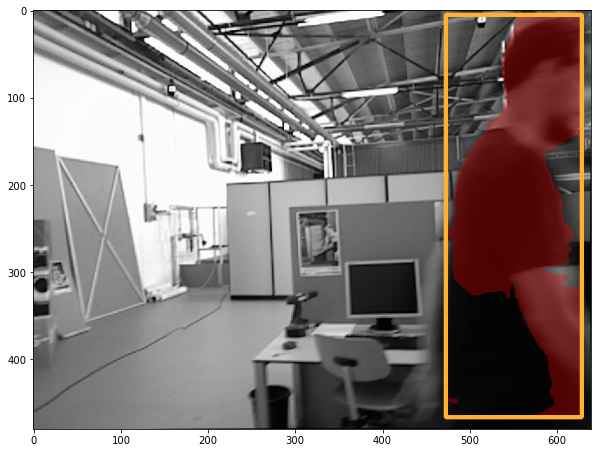

In [38]:
idx = torch.nonzero(t[0]==0).squeeze()  # 筛选所有是人的 index
masks = torch.index_select(t[3], 0, idx)
classes, scores, boxes = [torch.index_select(x, 0, idx).cpu().numpy() for x in t[:3]]

temp = np.zeros((frame.shape[0],frame.shape[1],3))
for i in range(3):
    temp[:,:,i] = gray[:,:]
frame = temp.astype(np.uint8)
for select in range(1):  # for select in range(len(classes)):
    x1, y1, x2, y2 = boxes[select].astype(np.int16)
    mask = masks[select][y1:y2, x1:x2].cpu().numpy() > 0
    roi = frame[y1:y2, x1:x2][mask]
    frame[y1:y2, x1:x2][mask] = ([0.3*255, 0.3*0, 0.3*0] + 0.7 * roi).astype(np.uint8)
    cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 178, 50), 3)
plt.figure(figsize=(10,10))
plt.imshow(frame)

## 绘制区域生长分割与语义分割结合 mask

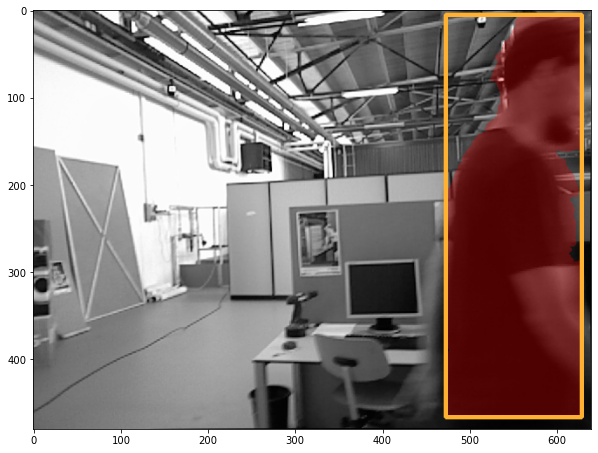

In [170]:
idx = torch.nonzero(t[0]==0).squeeze()  # 筛选所有是人的 index
masks = torch.index_select(t[3], 0, idx)
classes, scores, boxes = [torch.index_select(x, 0, idx).cpu().numpy() for x in t[:3]]
mask_one = mask_temp
mask_two = masks[select].cpu().numpy()
mask_add = mask_one + mask_two
temp = np.zeros((frame.shape[0],frame.shape[1],3))
for i in range(3):
    temp[:,:,i] = gray[:,:]
frame = temp.astype(np.uint8)
for select in range(1):  # for select in range(len(classes)):
    x1, y1, x2, y2 = boxes[select].astype(np.int16)
    mask = mask_add[y1:y2, x1:x2] > 0
    roi = frame[y1:y2, x1:x2][mask]
    frame[y1:y2, x1:x2][mask] = ([0.3*255, 0.3*0, 0.3*0] + 0.7 * roi).astype(np.uint8)
    cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 178, 50), 3)
plt.figure(figsize=(10,10))
plt.imshow(frame)

In [ ]:
# Look at the output predictions.
dets = preds[0]

print('Scores:', dets['score'][:args.top_k])
print('Classes:', dets['class'][:args.top_k])
print('Boxes:', dets['box'][:args.top_k])

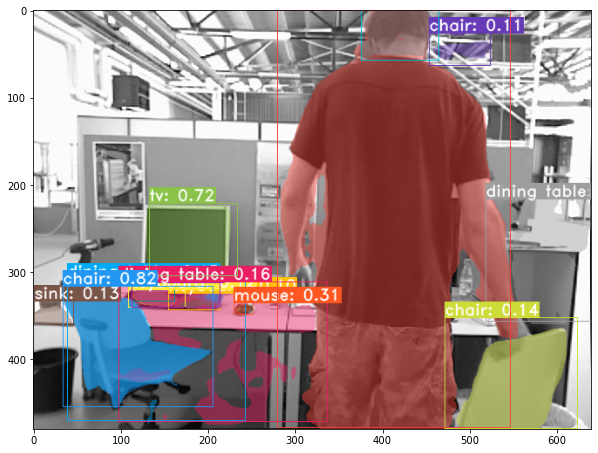

In [8]:
# Visualize the predictions

img_numpy = prep_display(preds, frame, None, None, undo_transform=False)

plt.figure(figsize=(10,10))
plt.imshow(img_numpy[:,:,::-1])

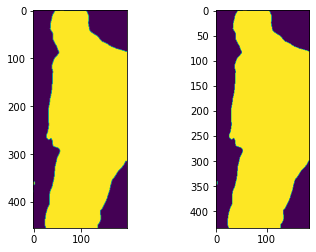

In [185]:
idx = torch.nonzero(t[0]==0).squeeze()  # 筛选所有是人的 index
masks = torch.index_select(t[3], 0, idx)
classes, scores, boxes = [torch.index_select(x, 0, idx).cpu().numpy() for x in t[:3]]

select = 1

x1, y1, x2, y2 = (boxes[select]*1.05).astype(np.int16)
mask = masks[select].cpu().numpy()
# mask = masks[0].bool().cpu()[y1:y2,x1:x2]
mask2 = cv2.resize(mask,(0,0),fx=1.05,fy=1.05)
plt.subplot(1,2,1)
plt.imshow(mask2[y1:y2,x1:x2])
plt.subplot(1,2,2)
plt.imshow(mask[boxes[select][1]:boxes[select][3],boxes[select][0]:boxes[select][2]])
mask.shape, mask2.shape,x1, y1, x2, y2

mask2 = mask2[y1:y2, x1:x2]>0

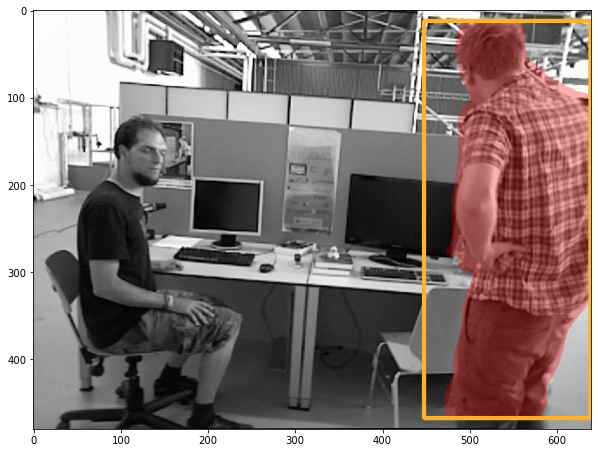

In [186]:
# x1, y1,x2,y2 = x1-0.025*(boxes[select][0]+boxes[select][2]), y1-0.025*(boxes[select][1]+boxes[select][3]), x2-0.025*(boxes[select][0]+boxes[select][2]), y2-0.025*(boxes[select][1]+boxes[select][3])
x1, y1 = x1-0.025*(boxes[select][0]+boxes[select][2]), y1-0.025*(boxes[select][1]+boxes[select][3])
if x1 >= 0:
    x1 = int(x1)
    x2 = x1 + mask2.shape[1]
else:
    x2 = mask2.shape[1] + int(x1)
    mask2 = mask2[:,-int(x1):]
    x1 = 0
if x2 >= 640:
    mask2 = mask2[:,:639-x2]
    x2 = 639
if y1 >= 0:
    y1 = int(y1)
    y2 = y1 + mask2.shape[0]
else:
    y2 = mask2.shape[0] + int(y1)
    mask2 = mask2[-int(y1):,:]
    y1 = 0
if y2 >= 480:
    mask2 = mask2[:479-y2,:]
    y2 = 479


temp = np.zeros((frame.shape[0],frame.shape[1],3))
for i in range(3):
    temp[:,:,i] = gray[:,:]
frame = temp.astype(np.uint8)
roi = frame[y1:y2, x1:x2][mask2]
frame[y1:y2, x1:x2][mask2] = ([0.3*255, 0.3*0, 0.3*0] + 0.7 * roi).astype(np.uint8)
cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 178, 50), 3)
plt.figure(figsize=(10,10))
plt.imshow(frame)

# 测试　TensorRT

In [ ]:
!pwd

/home/wxl/graduate/dyslam_ws/src/yolact_ros/scripts/faster_yolact


In [ ]:
import torch
from torch2trt import torch2trt
from torchvision.models.alexnet import alexnet

In [ ]:
# create some regular pytorch model...
model = alexnet(pretrained=True).eval().cuda()
 
# create example data
x = torch.ones((1, 3, 224, 224)).cuda()
 
batch_size = 1

In [ ]:
# convert to TensorRT feeding sample data as input
model_trt = torch2trt(model, [x])

In [ ]:
import time
t0 = time.time()
y = model(x)
print("Use {:2f} ms".format((time.time() - t0)*1000))

In [ ]:
t0 = time.time()
y_trt = model_trt(x)
print("Use {:2f} ms".format((time.time() - t0)*1000))

# 测试 Open_CV

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
frame = np.zeros((480,640,3))
frame_bin = np.ones((480,640,1))
mask = np.array((100,100),255)
mask[2,2] = 0
mask = (mask > 0)
roi = frame_bin[100:200, 100:200][mask]
frame_bin[100:200, 100:200][mask] = (0 + 0 * roi).astype(np.uint8)
plt.imshow(frame_bin,cmap='gray')